In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import tomllib
from sklearn.metrics import r2_score
import matplotlib as mpl

import copy

In [3]:
def dew_point_cacl(t, h):
    """t- температура в градусах цельсия, h - влажность воздуха в виде ХХ"""
    a, b = 17.27, 237.7
    g = a * t / (b + t)
    h = np.clip(h, 1e-6, 100.0)
    g += np.log(h / 100)
    dp = (b * g) / (a - g)
    return dp

In [4]:
alldata = pd.read_feather("meteo.feather")
alldata=alldata.rename(columns={'id_s':'sensor_id'})
# time_l = (alldata["datetime"].max() - pd.Timedelta(days=20)).replace(minute=0, second=0)
# time_r = (alldata["datetime"].max() - pd.Timedelta(days=0)).replace(minute=0, second=0)
# # data_timesort = alldata[(alldata["datetime"] > time_r) & (time_l > alldata["datetime"])]
# data_timesort =alldata[alldata["datetime"] >time_l ]

# data_timesort2 = data_timesort[data_timesort["id_s"] == "5"]
# # data = data_timesort[data_timesort["id_s"] == "5"].reset_index()
# data = copy.copy(data_timesort2).reset_index()
# # data["temp_air"] = data["temp_air"] + 8
# # data["hum_air"] = data["hum_air"] + 30

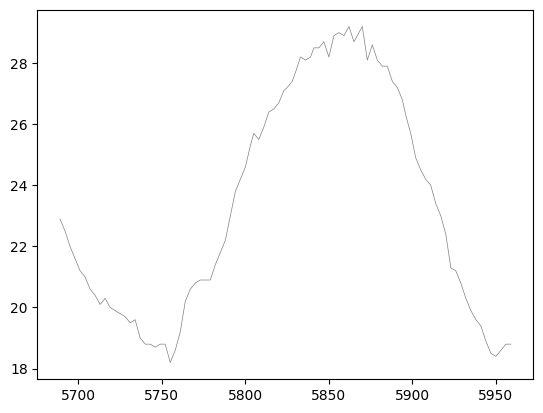

In [4]:
l = {}
d = {}
plt.figure()
# for id in alldata['id_s'].unique():
intg = []
for id in ["5"]:

    a = []
    b = []
    date_min = alldata["datetime"].min()
    date_max = alldata["datetime"].max()
    # Генерируем даты по дням в диапазоне
    i = 0
    for d in pd.date_range(date_min.date(), date_max.date(), freq="D"):
        sensdata = alldata[alldata["id_s"] == id]
        target_date = d
        mask = sensdata["datetime"].dt.normalize() == target_date
        subset = sensdata[mask]
        a.append(subset["temp_air"].to_list())

        if i == 26:
            plt.plot(subset["temp_air"], c="black", alpha=0.5, lw=0.5)
            break
        else:
            i += 1
        # print(b)
    # l[id]=a
    # d[id]=b

In [54]:
a=[1,2,3,4]
np.cumsum(a)

array([ 1,  3,  6, 10])

In [52]:
def compute_degree_days(df, T_min=5.0, T_max=100.0,countlim=60,timelim=120):
    """
    Вычисляет градусо-дни за один день.

    Параметры:
        df (pd.DataFrame): Данные за один день с колонками 'datetime' и 'temp_air'.
        T_min (float): Пороговая температура (по умолчанию 5.0°C).
        T_max (float): Пороговая температура (по умолчанию 100.0°C), если градусо-день выше данного значения он равен ему.

    Возвращает:
        float: Значение градусо-дней.
    """
    if type(dd)!=pd.DataFrame:
        df=pd.DataFrame(df,collumns=['datetime','temp_air'])
    if df.empty:
        return 0.0
    if len(df)<countlim or df['datetime'].diff().max().total_seconds()<time*60:
        return 0
    
    df = df.sort_values("datetime").copy()
    # Время в часах с начала дня
    start_date = df["datetime"].min().normalize()
    df["hour"] = (df["datetime"] - start_date).dt.total_seconds() / 3600.0

    df["excess"] = np.maximum(df["temp_air"]- T_min, 0) 
    # Интеграл методом трапеций
    degree_hours = np.trapezoid(df["excess"], x=df["hour"])
    dd=degree_hours / 24.0
    if dd>T_max:dd=T_max
    return dd

In [50]:
def interpolate_zeros(arr):
    """
    Интерполирует нули в 1D-массиве линейно по соседним ненулевым значениям.
    Параметры:
        arr (array-like): входной массив чисел.
    Возвращает:
        np.ndarray: массив с интерполированными нулями.
    """
    s = pd.Series(arr, dtype=float)
    s.replace(0, np.nan, inplace=True)
    # 'linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh',
    #  'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline'
    s.interpolate(method='linear', limit_direction='both', inplace=True)
    return s

In [53]:
def calc_dd_all_data(df,T_min=5,T_max=100, time=120):
    date_min = df["datetime"].min()
    date_max = df["datetime"].max()
    dd_df=pd.DataFrame()
    dd_df['date']=pd.date_range(date_min.date(), date_max.date(), freq="D")
    for id in df['sensor_id'].unique():
        sensdata = alldata[alldata["sensor_id"] == id]
        dd=[]
        for day in pd.date_range(date_min.date(), date_max.date(), freq="D"):
            mask = sensdata["datetime"].dt.normalize() == day
            day_data = sensdata[mask]
            dd.append(compute_degree_days(day_data, T_min,T_max))
        dd_df[id+'dd']=dd
        dd_df[id+'int']=interpolate_zeros(dd)
        dd_df[id+'cs']=dd_df[id+'ddint'].cumsum()
    return dd_df

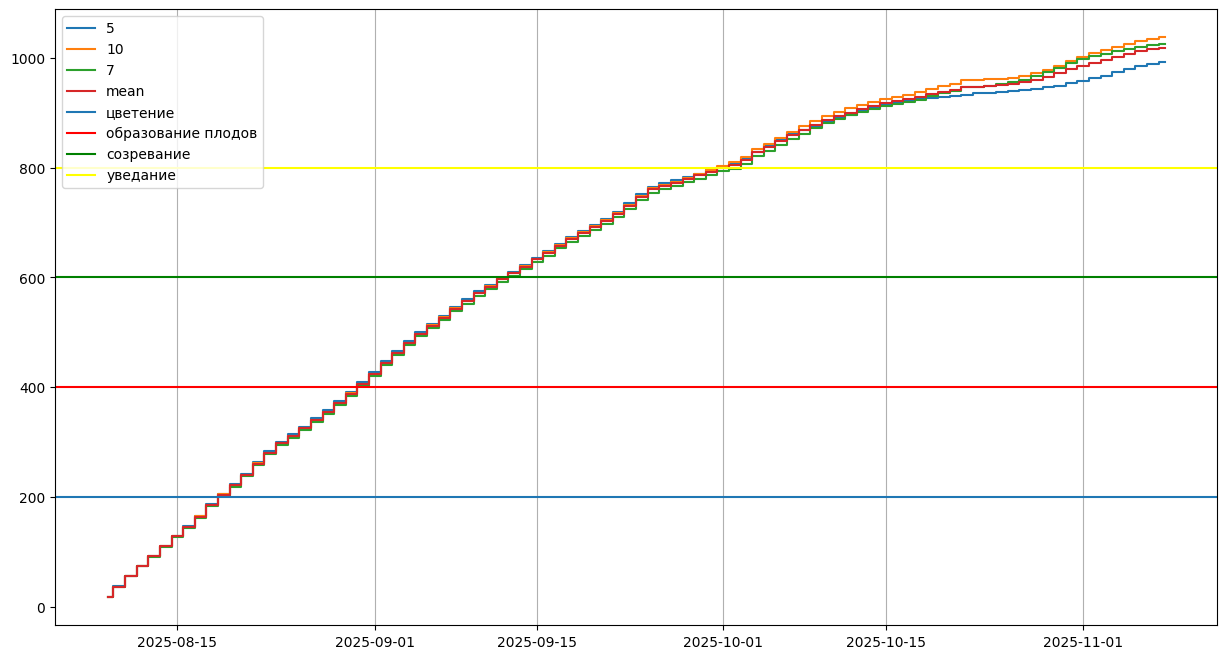

In [36]:
plt.figure(figsize=(15, 8))
plt.step(dd['date'], dd['5cs'],where='mid', label="5")
plt.step(dd['date'], dd['10cs'],where='mid', label="10")
plt.step(dd['date'], dd['7cs'],where='mid', label="7")
plt.step(dd['date'],dd[['5cs', '10cs', '7cs']].mean(axis=1),where='mid', label="mean")
plt.axhline(200,label='цветение')
plt.axhline(400,label='образование плодов',c='red')
plt.axhline(600,label='созревание',c='green')
plt.axhline(800,label='уведание',c='yellow')
plt.grid(axis='x')
plt.legend()

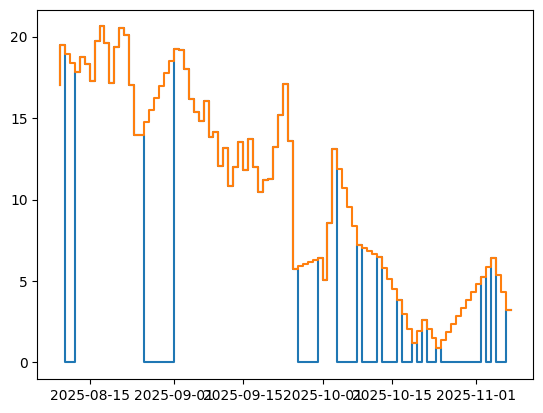

In [40]:
plt.step(dd['date'], dd['5dd'], label="integr")
plt.step(dd['date'], dd['5ddint'], label="integr")

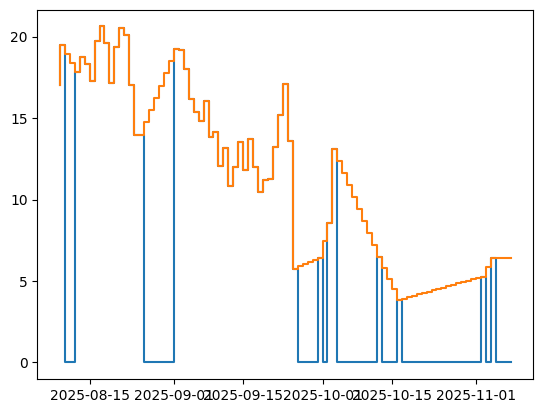

In [15]:
plt.step(dd['date'], dd['5dd'], label="integr")
plt.step(dd['date'], dd['5ddint'], label="integr")

In [8]:
plt.figure(figsize=(15, 8))
plt.step(date,sums[3], label="integral interpolate",where='mid')
plt.axhline(200,label='цветение')
plt.axhline(400,label='образование плодов',c='red')
plt.axhline(600,label='созревание',c='green')
plt.axhline(800,label='уведание',c='yellow')
plt.legend()
plt.xlim(pd.to_datetime('03.01.2025'),pd.to_datetime('12.12.2025'))

NameError: name 'date' is not defined

<Figure size 1500x800 with 0 Axes>

работа с toml

In [3]:
from scipy.signal import savgol_filter

C:\Users\nik\AppData\Local\Temp\ipykernel_1744\1161550894.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  extra_times = pd.date_range(


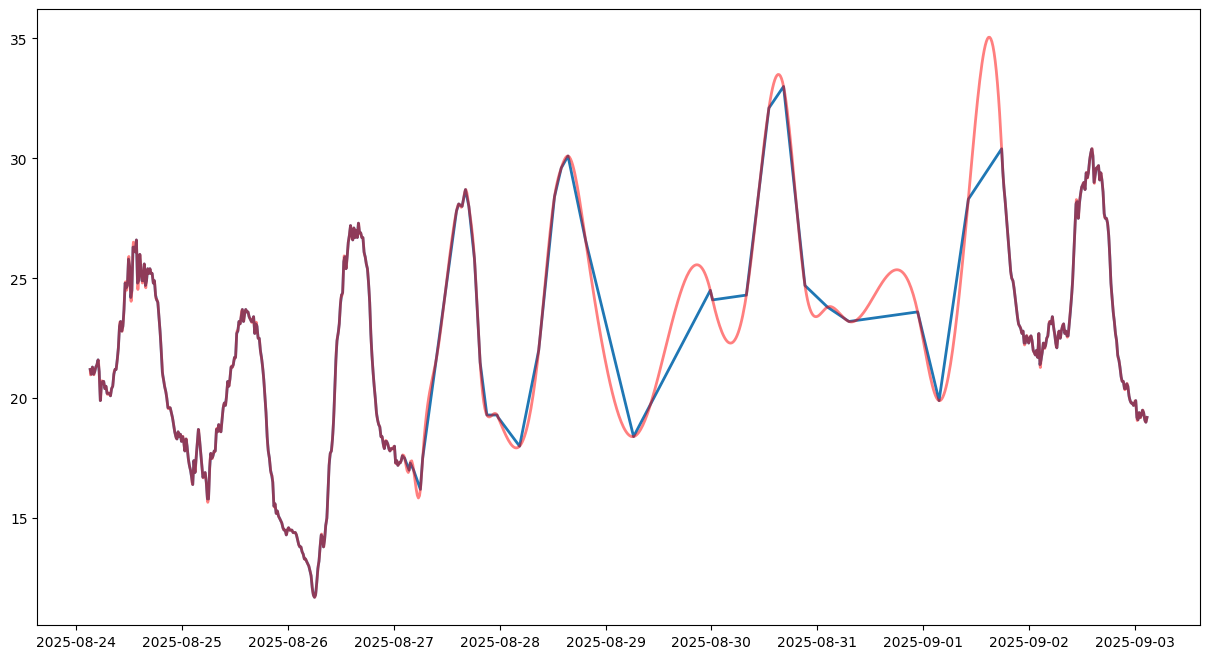

In [7]:
xt = [data["datetime"].min(), data["datetime"].max()]
x = data["datetime"]
tdata = fill_gaps_with_nan(data).set_index("datetime")
# 'linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh',
# 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline'
y = tdata["temp_air"].interpolate(method="cubicspline")
# y_smooth = savgol_filter(y, window_length=15, polyorder=2)
plt.figure(figsize=(15, 8))
plt.plot(data["datetime"], data["temp_air"], lw=2)
plt.plot(y, c="red", lw=2, alpha=0.5)
# plt.plot(y.index,y_smooth,c='red')
# plt.plot(xt,[10,10])
# plt.plot(xt,[30,30])

5


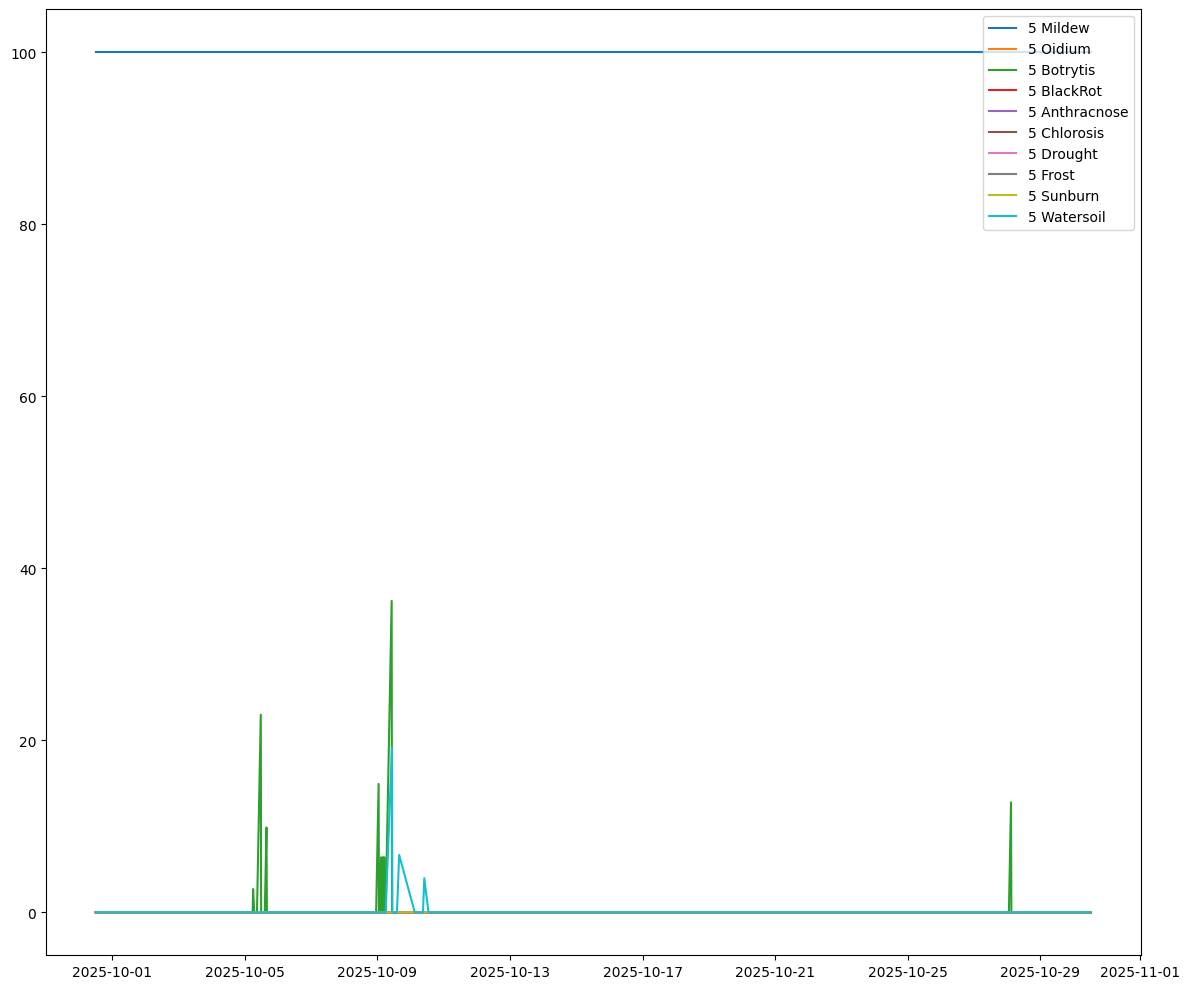

7


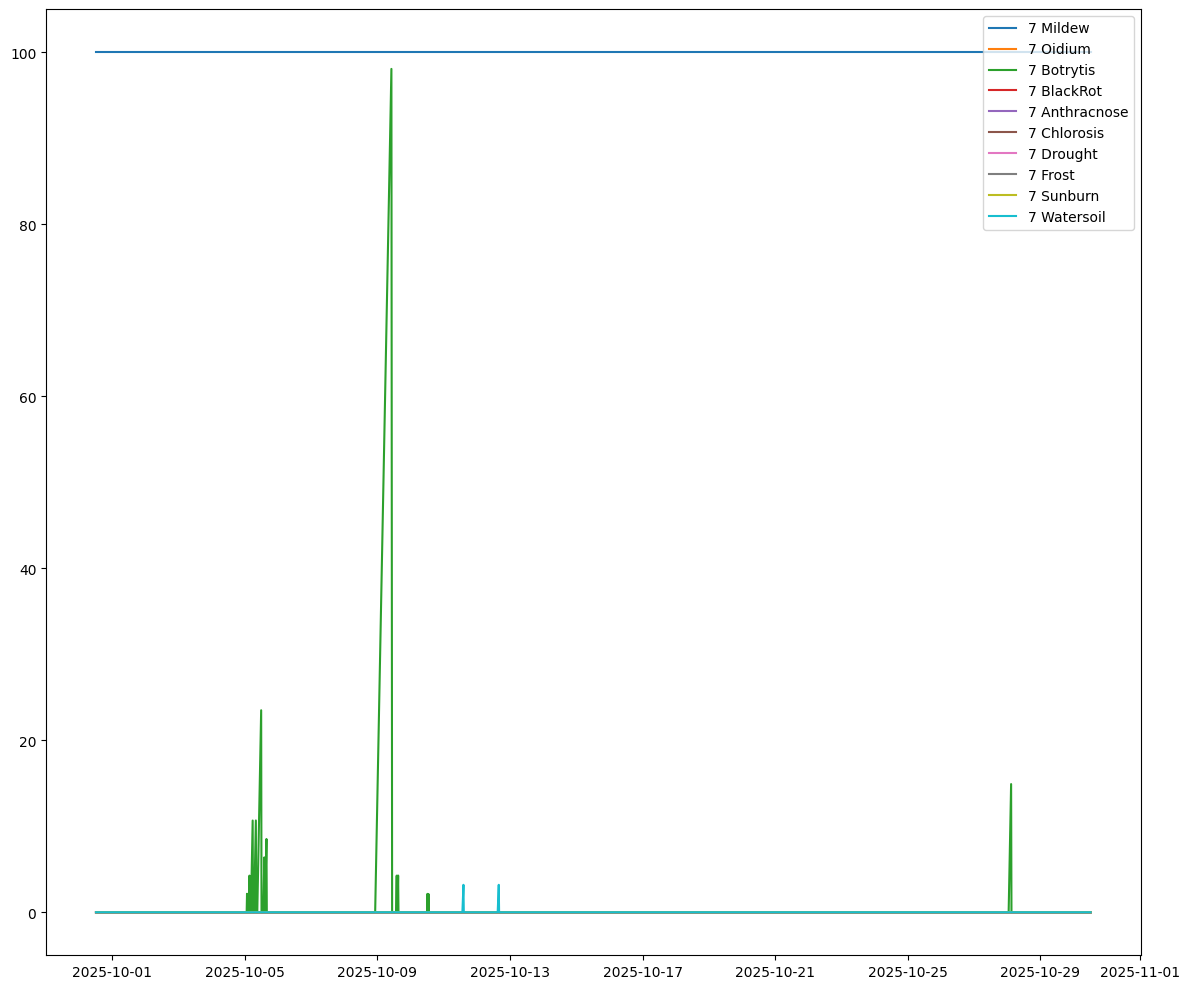

10


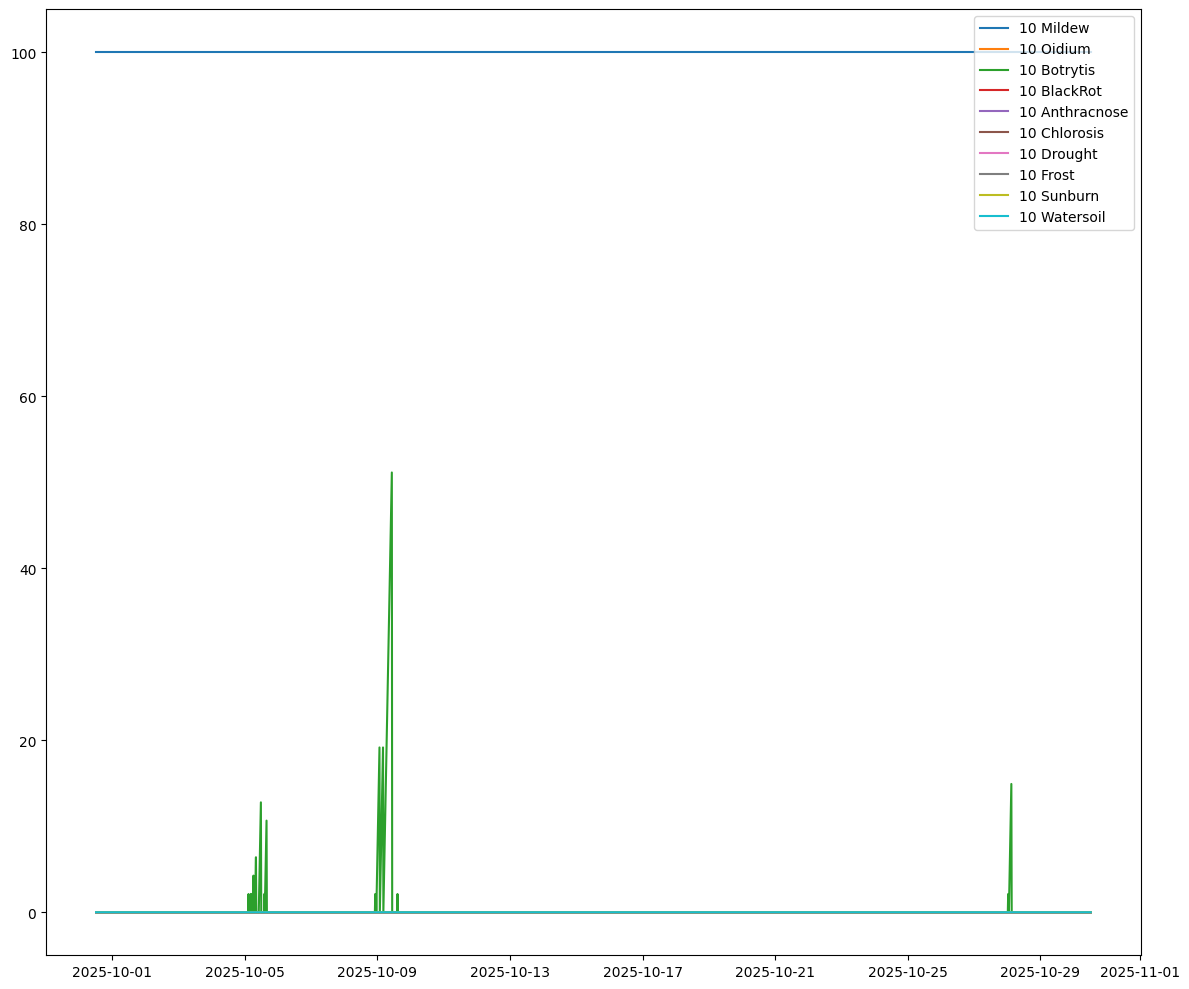

In [12]:
import Diseas

d = Diseas.Diseas_work("deseas_grape.toml", 0)
alldata = pd.read_feather("meteo.feather")
time_l = (alldata["datetime"].max() - pd.Timedelta(days=30)).replace(minute=0, second=0)
alldata = alldata[alldata["datetime"] > time_l]

for id in alldata["id_s"].unique():
    print(id)
    d.check_all_disease_for_one_sens(alldata[alldata["id_s"] == id], "all")
    # for d_name in d.names:
    #     print(d.prob[d_name].to_dict())
    plt.figure(figsize=(12, 10))

    for d_name in d.names:
        plt.plot(
            d.prob[d_name]["datetime"], d.prob[d_name]["prob"], label=id + " " + d_name
        )

    plt.plot([alldata["datetime"].min(), alldata["datetime"].max()], [100, 100])
    plt.legend(loc="upper right")
    plt.tight_layout()

    plt.show()
    plt.close()

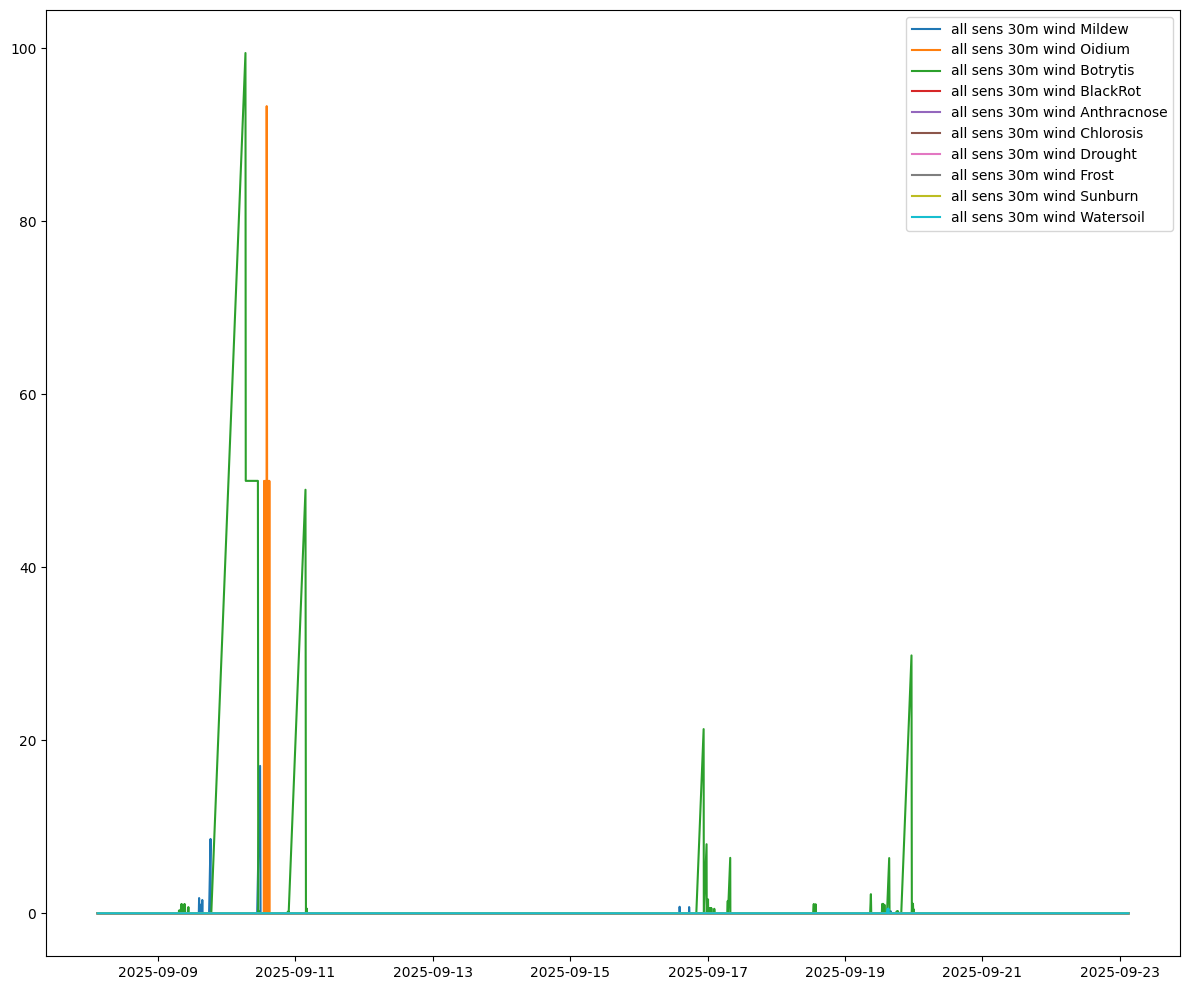

In [97]:
cdata = rolling_average_30min(alldata)
plt.figure(figsize=(12, 10))
d.check_time(tdata, 15 * 24)

for d_name in d.names:
    plt.plot(
        d.prob[d_name]["datetime"],
        d.prob[d_name]["prob"],
        label="all sens 30m wind " + d_name,
    )
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
plt.close()

In [6]:
d.diseas

{'Mildew':            min    max
 temp_air  19.5   25.5
 hum_air   78.0  102.0,
 'Oidium':            min   max
 temp_air  24.5  30.5
 hum_air   58.0  82.0,
 'Botrytis':            min    max
 temp_air  14.0   26.0
 hum_air   89.0  101.0,
 'BlackRot':            min    max
 temp_air  21.5   27.5
 hum_air   89.0  101.0,
 'Anthracnose':            min    max
 temp_air  24.5   30.5
 hum_air   89.0  101.0,
 'Chlorosis':              min     max
 temp_air   19.20   28.80
 temp_soil  17.30   25.70
 hum_soil   17.50  107.50
 ph          7.35    9.15,
 'Drought':               min      max
 temp_air     26.0     74.0
 hum_air      -4.0     44.0
 uv_index      4.3     12.7
 ilum       4500.0  10500.0
 temp_soil    26.5     68.5
 hum_soil     -1.5     16.5,
 'Frost':             min  max
 temp_air  -44.0  4.0
 temp_soil -44.5  9.5,
 'Sunburn':               min      max
 temp_air     32.0     68.0
 hum_air      -4.0     44.0
 uv_power    790.0   2110.0
 uv_index      8.7     12.3
 ilum       680

In [7]:
d.diseas_check

{'Mildew': np.True_,
 'Oidium': np.True_,
 'Botrytis': np.True_,
 'BlackRot': np.True_,
 'Anthracnose': np.False_,
 'Chlorosis': np.False_,
 'Drought': np.True_,
 'Frost': np.True_,
 'Sunburn': np.False_,
 'Watersoil': np.False_}

In [17]:
for d_name in d.names:
    print(d.prob[d_name].to_dict())

{'datetime': {2: Timestamp('2025-08-09 05:57:00'), 5: Timestamp('2025-08-09 06:12:22'), 8: Timestamp('2025-08-09 06:27:40'), 11: Timestamp('2025-08-09 06:43:02'), 14: Timestamp('2025-08-09 06:58:20'), 17: Timestamp('2025-08-09 07:13:42'), 20: Timestamp('2025-08-09 07:28:59'), 23: Timestamp('2025-08-09 07:44:22'), 26: Timestamp('2025-08-09 07:59:39'), 29: Timestamp('2025-08-09 08:15:02'), 32: Timestamp('2025-08-09 08:30:19'), 35: Timestamp('2025-08-09 08:45:42'), 38: Timestamp('2025-08-09 09:00:59'), 41: Timestamp('2025-08-09 09:16:22'), 44: Timestamp('2025-08-09 09:31:39'), 47: Timestamp('2025-08-09 09:47:02'), 50: Timestamp('2025-08-09 10:02:19'), 53: Timestamp('2025-08-09 10:17:42'), 56: Timestamp('2025-08-09 10:32:59'), 59: Timestamp('2025-08-09 10:48:22'), 62: Timestamp('2025-08-09 11:03:39'), 65: Timestamp('2025-08-09 11:19:02'), 68: Timestamp('2025-08-09 11:34:19'), 71: Timestamp('2025-08-09 11:49:42'), 73: Timestamp('2025-08-09 12:04:58'), 77: Timestamp('2025-08-09 12:20:22'), 7

In [22]:
d.prob_last

{'Mildew': np.int64(0),
 'Oidium': np.int64(0),
 'Botrytis': np.int64(0),
 'BlackRot': np.int64(0),
 'Anthracnose': np.int64(0),
 'Chlorosis': np.int64(0),
 'Drought': np.int64(0),
 'Frost': np.int64(0),
 'Sunburn': np.int64(0),
 'Watersoil': np.int64(0)}

In [21]:
d.time

{'Mildew': 6,
 'Oidium': 0.1,
 'Botrytis': 12,
 'BlackRot': 24,
 'Anthracnose': 12,
 'Chlorosis': 0.1,
 'Drought': 4,
 'Frost': 12,
 'Sunburn': 4,
 'Watersoil': 24}